In [1]:
%matplotlib widget

# Session 2

## First X-ray radiograph simulations with ![gVXR](../img/gvxr_logo.png)

## Authors: Ben Thorpe, Iwan Mitchel and Franck Vidal

(version 1.0, 22 Sep 2022)

# Aims of this session

- Create our first X-ray simulation, step-by-step;
- Save our X-ray image in a file format that preserves the original dynamic range;
- Visualise the results with 3 different look-up tables;
- Visualise the 3D environment.

![](img/02-visualisation.png)

# Main steps

There are 6 main steps to simulate an X-ray image:

1. Create a renderer (OpenGL context)
2. Set the X-ray source
3. Set the Spectrum
4. Set the Detector
5. Set the Sample
6. Compute the corresponding X-ray image.

![](img/dragon2.jpg)

## Import packages

This is essentially just boilerplate code to set everything up for the session. We don't need to know the exact details at this stage so for now we can safely run this cell and move on. However, for the curious the comments explain what the various packages are for.  

In [2]:
import os
import numpy as np # Who does not use Numpy?

import matplotlib # To plot images
import matplotlib.pyplot as plt # Plotting
from matplotlib.colors import LogNorm # Look up table
from matplotlib.colors import PowerNorm # Look up table

font = {'family' : 'serif',
         'size'   : 10
       }
matplotlib.rc('font', **font)

# Uncomment the line below to use LaTeX fonts
# matplotlib.rc('text', usetex=True)

from tifffile import imread, imwrite # Write TIFF files

import base64 # Save the visualisation

from gvxrPython3 import gvxr # Simulate X-ray images
from gvxrPython3.utils import saveProjections # Plot the X-ray image in linear, log and power law scales
from gvxrPython3.utils import compareWithGroundTruth # Plot the ground truth, the test image, and the relative error map in %
from gvxrPython3.utils import interactPlotPowerLaw # Plot the X-ray image using a Power law look-up table
from gvxrPython3.utils import visualise # Visualise the 3D environment if k3D is supported
from gvxrPython3.utils import plotScreenshot # Visualise the 3D environment if Matplotlib is supported

spekpy is not install, you won't be able to load a beam spectrum using spekpy


## Create an OpenGL context

Our first real step is to create what is known as an OpenGl context. This can be thought of a digital blank canvas onto which we will place our objects (Detector, Sample, X-ray source etc). Depending on your Operating system GVXR supports 2 different types of OpenGl contexts (backends), "OPENGL" and "EGL".

- "OPENGL" Creates an interactive window (available on Linux, MacOS, and Windows) for use on Laptop/desktop computers.
- "EGL" Creates a context without a window (available on Linux and MacOS, but not Windows) for use on supercomputers or the cloud.

For this tutorial (and the subsequent ones) we will stick with **"EGL"**, this is because we are using the Cloud for this training. On my PC and laptop, I would use "OPENGL" to enable an interactive 3D visualisation window.

In [3]:
print("Create an OpenGL context")

window_id = 0
opengl_major_version = 4
opengl_minor_version = 5

# gvxr.createOpenGLContext(window_id, opengl_major_version, opengl_minor_version);

# backend = "OPENGL"
# visible = True

# gvxr.createWindow(window_id, visible, backend, opengl_major_version, opengl_minor_version);

visible = False
# gvxr.createWindow(window_id, visible, backend, opengl_major_version, opengl_minor_version);

#backend = "EGL"
backend = "OPENGL"
# visible has no effect with EGL
gvxr.createWindow(window_id, visible, backend, opengl_major_version, opengl_minor_version);

Create an OpenGL context


## Setting up the X-ray source

To start producing X-ray images we first need to define an X-ray source. This requires 3 basic parameters:

1. The position of the source
2. The beam shape
3. The beam energy (spectrum)

To set the position of the X-ray source we use the `gvxr.setSourcePosition(x,y,z,units)` function. it takes in 4 values. The x,y and z coordinates as 3 floating point (decimal) values and a string (literal letters or numbers surrounded by quotes) to denote the units ("mm","cm","m" etc ...).

For the beam shape. GVXR allows for two choices
- Cone beam: `gvxr.usePointSource()`
- Parallel beam (e.g. synchrotron): `gvxr.useParallelBeam()`

Finally we need to set the beam spectrum. Out of the box GVXR supports Monochromatic and PolyChromatic sources. You can also use other external packages (e.g. Spekpy) to generate more realistic/complex spectra. This will be covered in a later session. For now we will stick with a simple Monochromatic source. This can be set with the function `gvxr.setMonoChromatic(energy,unit_of_energy,number_of_photons)`. This takes in three values a float for the beam energy. A string to denote the energy units (can be any of "eV", "keV" or "MeV" take care with capitalisation) and an integer (whole number) for the number of photons.

---

## Task: 

In the next code cell:
- Set the X-ray Source to be at position x = 0.0 cm, y = -40.0 cm and z = 0.0 cm.
- Set the beam shape to be a cone beam.
- Use the `setMonoChromatic` function to define a monochromatic X-ray source with:
    - energy 0.08 MeV (i.e. 80 keV) 
    - 1000 photons per ray.

In [4]:
gvxr.setSourcePosition(0.0 ,-40.0,0.0,"cm")
gvxr.usePointSource()
gvxr.setMonoChromatic(0.08,"MeV",1000)

## Setting up the detector:

In GVXR the X-ray detector is defined as a 2D plane of evenly spaced pixels. Thus we need to specify 4 things:

1. The resolution (number of pixels in x and y)
2. The Pixel spacing (this defines the physical size of the detector)
3. The position of the top left corner
4. It's orientation in 3D space

The resolution is set with `gvxr.setDetectorNumberOfPixels(Px,Py)` where Px and Py are integers defining the number of pixels in x and y respectively. Note: this is also the resolution of the final output image.

The pixel spacing is set with `gvxr.setDetectorPixelSize(width,height,units)` where width and height are floating point numbers defining the physical distance between pixels and units is once again a string to denote the units ("mm","cm","m" etc ...). Note: The Pixel spacing and resolution together define the physical size of the detector. For example a detector with with 600 pixels in x and 300 in y with a spacing of 0.1 mm in both directions would have a physical size of 60 mm by 30 mm.

The position of the X-ray detector is taken from the top-left corner, which is just a convention in computer graphics. It is defined in much the same way as for the X-ray source. Only we use the `gvxr.setDetectorPosition(x,y,z,units)` function. Much like the source case this function takes in 4 values. The x,y and z coordinates as 3 floating point values and a string to denote the units ("mm","cm","m" etc ...).

Finally since the detector is just a 2D plane we also need to set its orientation in 3D space. To do this we need to use `gvxr.setDetectorUpVector(ix,jy,kz)`. Here, the three inputs ix, jy and kz represent a unit vector, the direction of which points along the Y-axis of our detector. Note: By convention we generally define this to point along an axis in 3D space. 

---

### Task:
With all this in mind. In the next cell set the top left corner of the detector to be at `x = 0.0 cm`, `y = 10.0 cm` and `z = 0.0 cm`. Also set the detector resolution to 640 by 320 pixels, spaced 0.5 mm apart in both x and y. Finally, set the Y-axis of the detector along the unit vector `(0,0,-1)`. That is pointing along the **negative** Z-axis.


In [5]:
gvxr.setDetectorNumberOfPixels(640,320)
gvxr.setDetectorPixelSize(0.5,0.5,"mm")
gvxr.setDetectorPosition(0.0,10.0,0.0,"cm")
gvxr.setDetectorUpVector(0,0,-1)

## Setting up the sample

For our sample we need specify four things:
1. A 3D model of the object (stl file) 
2. A unique ID, so we can refer to the model later
3. What the Sample is made from
4. It's position and orientation

For the sample we are going to use the Welsh Dragon Model which was released by [Bangor university UK, for Eurographics 2011](http://vmg.cs.bangor.ac.uk/downloads). This model is saved as an stl file included with this notebook under `input_data/welsh-dragon-small.stl`. To use this with GVXR we first need to import the 3D model into GVXR as a mesh using `gvxr.loadMeshFile(ID,fname,unit_of_length)`. 

where
- ID is a string to give the model a name for use with later functions.
- fname is a string defining the path to the model file (i.e. where the model file is on your computer) in our case "input_data/welsh-dragon-small.stl"
- Unit_of_length once again a string defining the units used in the model (in this case "mm").

### Set Material of the sample:

The next thing we need before computing our X-Ray image is to define the sample material. We will cover this in more detail in the next section but for now we will keep things simple and set the sample to be made from a single element. 

- For a chemical element such as iron, you can use the name, atomic (Z) number or symbol:
    - `gvxr.setElement(ID, "Iron")`
    - `gvxr.setElement(ID, 26)`, or
    - `gvxr.setElement(ID, "Fe")`

---

### Task:

Load the dragon model into the scene with the ID "Dragon" and set the sample to be made entirely from Titanium (Hint the Z number is 22).

In [6]:
ID = "Dragon" 
gvxr.loadMeshFile(ID,"../input_data/welsh-dragon-small.stl","mm")
gvxr.setElement(ID, 22)

## Viewing our results so far

Now that we have our sample imported we can view our work so far. For this we can use `gvxr.displayScene()` to update the scene and render a static view to the window.  

Try running this in the next cell. You will notice that the source and detector both look fine. However, the model is not visible. It is actually in the scene, just in wrong place. We need it in the centre and it's actually way off frame to the bottom left and in the wrong orientation. So lets fix that.

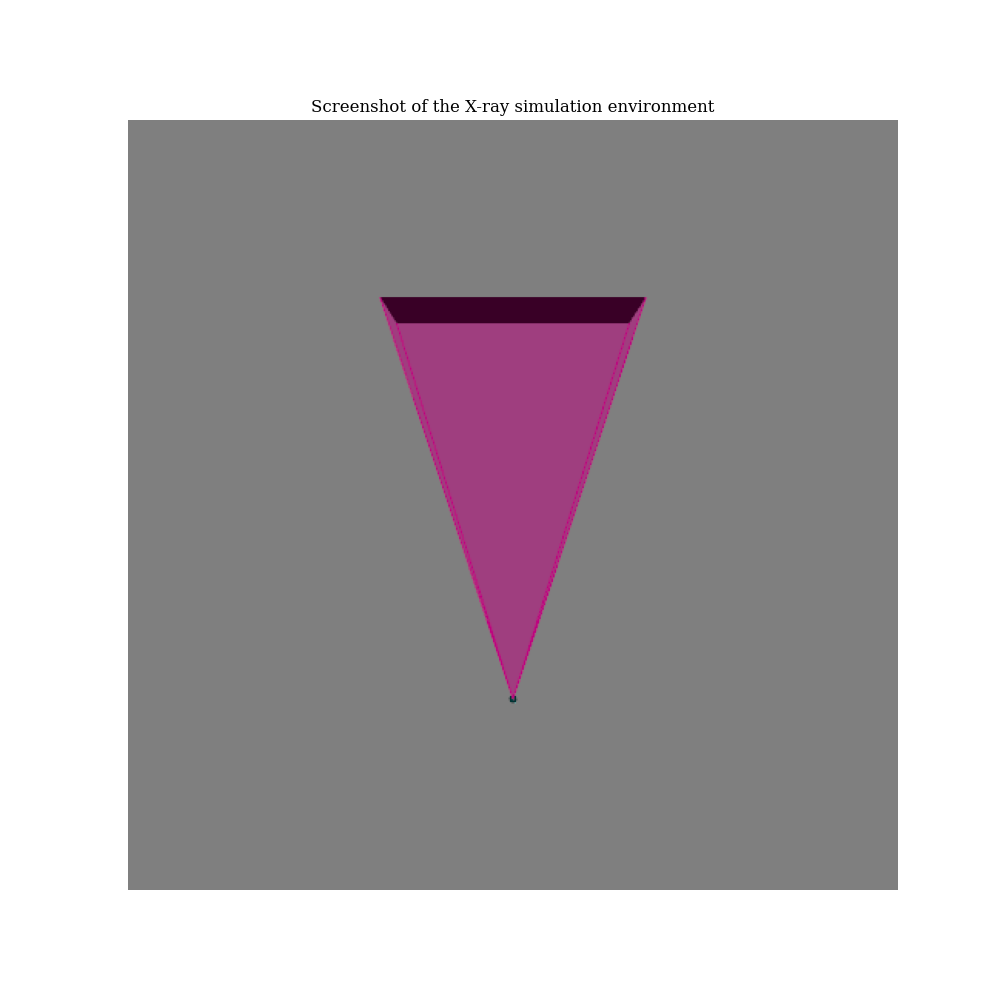

In [7]:
plotScreenshot()

### Model Wrangling

From the picture above, it's clear we have a problem. The coordinates of the 3D object in the STL file are not centred on (0, 0, 0). We could move the source and detector with the functions we already used, but it's not convenient.

---
### Task:

Check the current location of the dragon. You could use a 3rd party software such as [MeshLab](https://www.meshlab.net/) or [Paraview](https://www.paraview.org/), or better call `gvxr.getNodeAndChildrenBoundingBox(ID, units)` and print the returned values. The function returns an array of 6 floating-point numbers as follows:

- Lower corner of the bounding box:
    - min x position;
    - min y position;
    - min z position.
- Upper corner of the bounding box:
    - max x position;
    - max y position;
    - max z position.
    
From these values, compute and print the centre of the bounding box.

In [8]:
ID = "Dragon"
[min_x, min_y, min_z, max_x, max_y, max_z] = gvxr.getNodeAndChildrenBoundingBox(ID, "cm")

centre_x = (min_x + max_x) / 2.0
centre_y = (min_y + max_y) / 2.0
centre_z = (min_z + max_z) / 2.0

print("Lower bbox corner:", [min_x, min_y, min_z], "in cm")
print("Upper bbox corner:", [max_x, max_y, max_z], "in cm")
print("Bbox centre:", [centre_x, centre_y, centre_z], "in cm")

Lower bbox corner: [-4.470652103424072, -74.93681335449219, 23.590932846069336] in cm
Upper bbox corner: [2.374824285507202, -59.425575256347656, 36.03434371948242] in cm
Bbox centre: [-1.047913908958435, -67.18119430541992, 29.81263828277588] in cm


### Geometrical transformations

The basic functions to move, rotate and rescale a model are as follows:
- `gvxr.rotateNode(ID, angle, ix, jy, kz)`
- `gvxr.translateNode(ID, x, y, z, units)`
- `gvxr.scaleNode(ID, x, y, z)`

`rotateNode` takes in an ID, an angle in degrees and a vector to rotate around. 
`translateNode` takes in an ID, x, y, z coordinates to translate the centre of the object by and a string to denote units. For example if the centre of the object was at (0, 3, -5) and we pass in X=3, Y=0, Z=5, its centre would then be translated to (3, 3, 0).
`scaleNode` takes in an ID and 3 scaling factors to rescale an object. (0.5, 0.5, 0.5) would make the object twice as small; (2, 2, 2) twice as big. With (1, 1, 1), its size will remain the same.

---
### Task:

With this we should be able to fix our current setup. 

1. Centre the object using `translateNode` with *minus* the centre of the bounding box as the translation vector.
2. Check again the location of its bounding box (to be on the safe side). 

<!-- 

In the next cell rotate the sample by 90 degrees around the Z-axis (0, 0, 1) then move the sample into the position `X=0.1 mm`, `Y=-0.1 mm`, `Z=0.3 mm`. 
 -->
<!-- **Note:** Due to how clunky translations are in OpenGl we suggest you use `moveToCentre`. Then use `translateNote` to get it to an exact position since: a) it's much easier to use the origin as a known reference point for this, and b) in reality you may not know exactly where the model is spawned. However, if you fancy a challenge you can try doping it in one translation operation. In which case the centre of the model is located at (-10.4791, -671.812, -173.692). Don't forget to use 'displayScene to update the scene and view the result. -->

In [9]:
ID = "Dragon"
gvxr.translateNode(ID, -centre_x, -centre_y, -centre_z, "cm")

#Get the updated centre of the dragon's bounding box
[min_x, min_y, min_z, max_x, max_y, max_z] = gvxr.getNodeAndChildrenBoundingBox(ID, "cm")

centre_x = (min_x + max_x) / 2.0
centre_y = (min_y + max_y) / 2.0
centre_z = (min_z + max_z) / 2.0

print("Lower bbox corner:", [min_x, min_y, min_z], "in cm")
print("Upper bbox corner:", [max_x, max_y, max_z], "in cm")
print("Bbox centre:", [centre_x, centre_y, centre_z], "in cm")

Lower bbox corner: [-3.4227378368377686, -7.755621433258057, -6.221704006195068] in cm
Upper bbox corner: [3.4227383136749268, 7.755621433258057, 6.221707344055176] in cm
Bbox centre: [2.384185791015625e-07, 0.0, 1.6689300537109375e-06] in cm


## Viewing our results so far

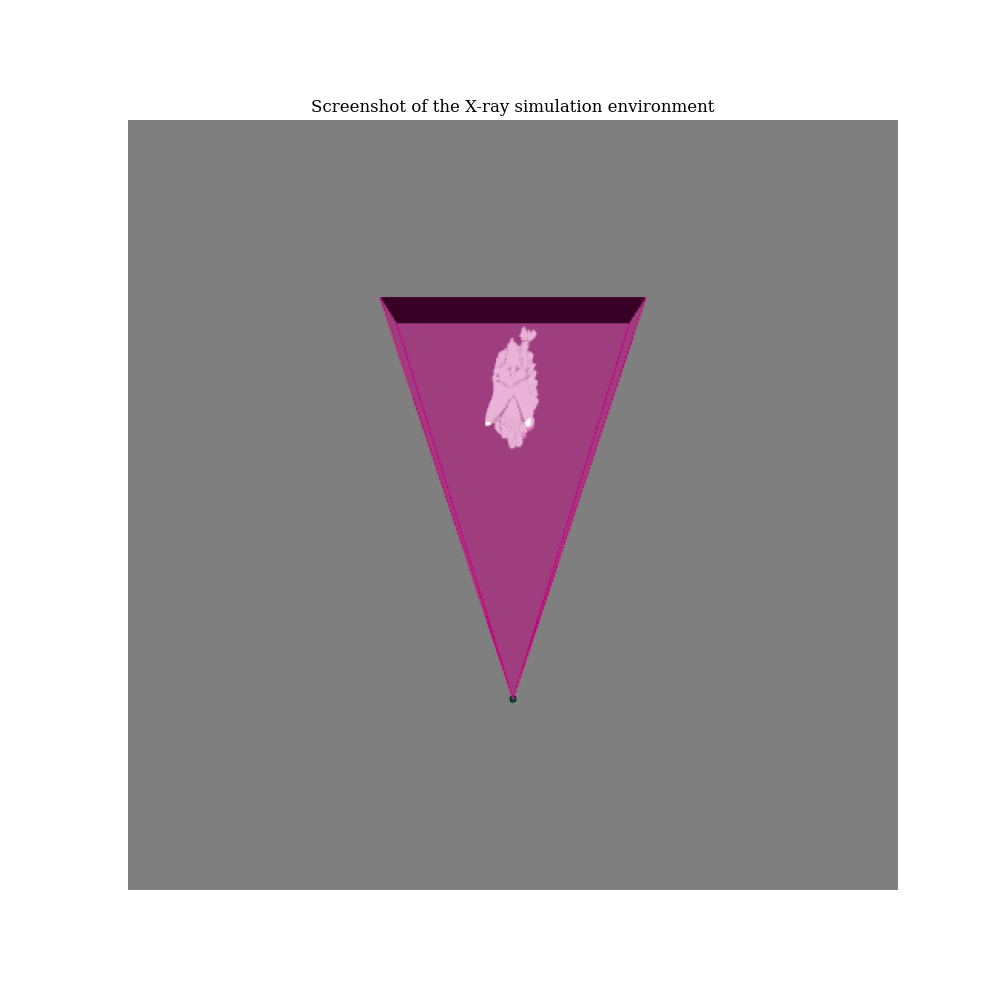

In [10]:
plotScreenshot()

It will be nicer if the dragon is rotated by 90 degrees along the Z-axis.

<div class="alert alert-block alert-warning">
    <b>Note:</b> Due to the way geometrical transformations are applied (matrix multiplications), the order of transformations is very important. 
</div>

Let's consider:

$$position_{new} = T_1 \times T_2 \times position_{old}$$

with $T_1$ the matrix of a given geometrical transformation, $T_2$ the matrix of another geometrical transformation, $position_{old}$ the position of the vertex to transform, and $position_{new}$ the position of the vertex after transformation. 

It is clear that $T_1$ is written first in the equation (hence called first in the Python code). However, if we rewrite the equation as follows:

$$position_{new} = T_1 \times (T_2 \times position_{old})$$

It is clear that $T_2$ is applied first on the vertex. In a nutshell, the last function called is the first one that is applied on the object. In other words

```python
gvxr.rotateNode(ID, angle, ax, ay, az)
gvxr.translated(ID, tx, ty, tz)
```

**IS NOT** the same as
```python
gvxr.translated(ID, tx, ty, tz)
gvxr.rotateNode(ID, angle, ax, ay, az)
```

How does it matter for us in this case? We should have translated, then rotated, i.e. called the function in the order as follows:

```python
ID = "Dragon"
gvxr.rotateNode(ID, 90, 0.0, 0.0, 1.0)
gvxr.translateNode(ID, -centre_x, -centre_y, -centre_z, "cm")
```

but we did the opposite. Ooops, We did not know. To fix it, we could:

1. restart from the start and do it again but in the right order, 
2. we could reverse the changes we did so far, then do it right, or
3. we can be lazy. The lazy solution is always the better (less prone to errors). There is a useful convenience function `gvxr.moveToCentre()` (or `gvxr.moveToCenter()` if you prefer the American spelling). It moves all the samples so that the centre of the overall bounding box is at (0, 0, 0). 
<!-- You can pass in an ID into this function to move a specific model or you can give it no arguments to move all models in the scene to the centre.  -->

---
### Task:

1. Rotate the dragon by 90 degrees around the Z-axis
2. Move the object to the centre. Use the 3rd solution from the above list.
3. Display the 3D visualisation

In [11]:
gvxr.rotateNode(ID, 90, 0.0, 0.0, 1.0)
gvxr.moveToCentre()

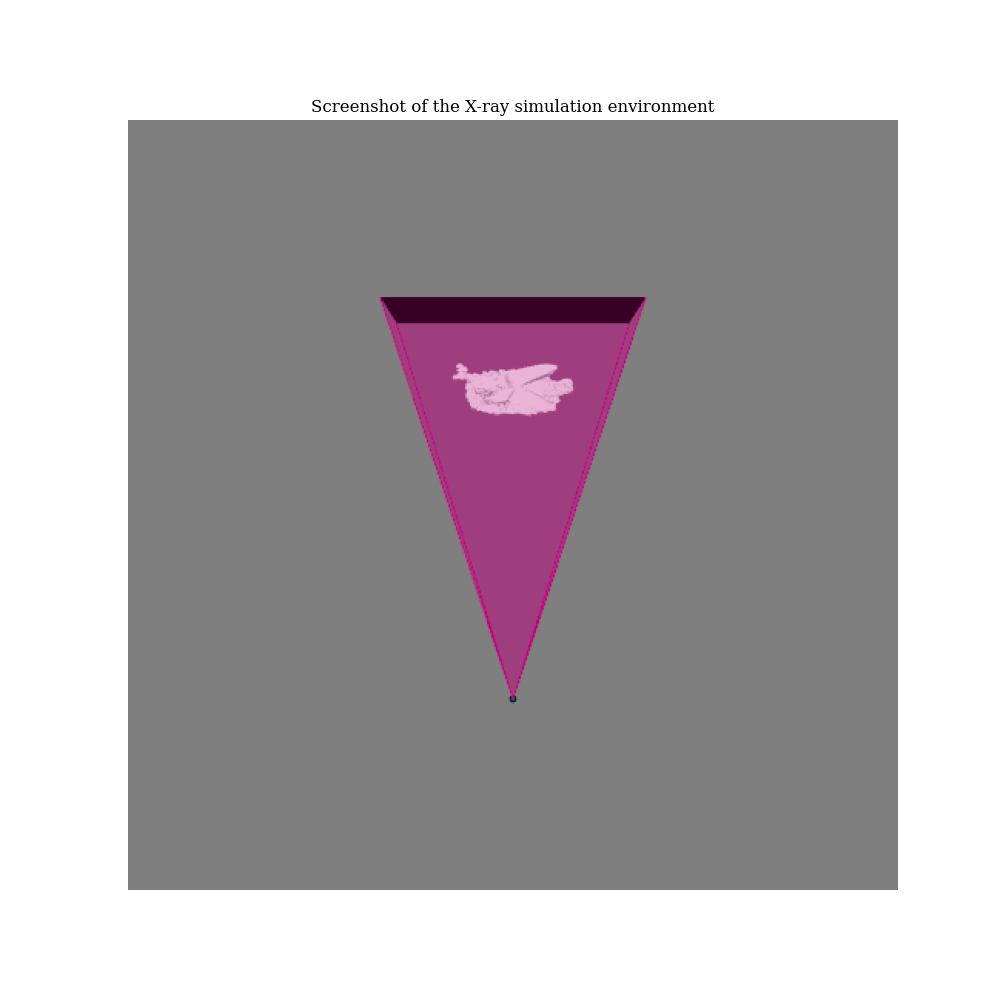

In [12]:
plotScreenshot()

## Compute the corresponding X-ray image

The final step in our process is to compute the actual X-Ray projection. This is achieved with the function `gvxr.computeXRayImage()` which outputs the X-Ray image as a 2D array. This can then be processed in numerous ways with various python packages. You can also save the last X-ray image as a tiff file with `gvxr.saveLastXRayImage(filename)`. Alternatively you can use the the tifffile package to achieve the same thing.

```python
from tifffile import imwrite
imwrite(
    filename, # string
    xray_image # 2D array
)
```

You can also use the python image library (PIL) to do more advanced image manipulations such as saving the array to common image formats (png, raw or jpeg to name a few). You can also convert images to use 8 or 16 bit greyscale for tools that need it. **Note:** PIL is a very powerful library and can do a lot more than just convert images see the [docs](https://pil.readthedocs.io/en/latest/overview.html) if you are interested.

``` python
from PIL import Image
max_int = 255 # change to 65535 for 16 bit
xray_image = xray_image*max_int # convert from 0 -> 1 scale to 0 -> max_int
im = Image.fromarray(xray_image)
#im = im.convert('I;16') #for 16-bit greyscale
im = im.convert('L') #for 8-bit greyscale
im.save('filename.png')
```

---

### Task:

The final task is to compute the xray image then save the resulting array as a tif image file using whichever method you prefer.

In [13]:
xray_image = np.array(gvxr.computeXRayImage()).astype(np.single)
# Create the output directory if needed
if not os.path.exists("output_data"):
    os.mkdir("output_data")
# write x-rayimage to file
gvxr.saveLastXRayImage('output_data/02-gvxr-save.tif')

# Display the X-ray image

What follows is a variety of different examples of visualisations and analysis you can preform on the xray images.

### Plot using a linear colour scale

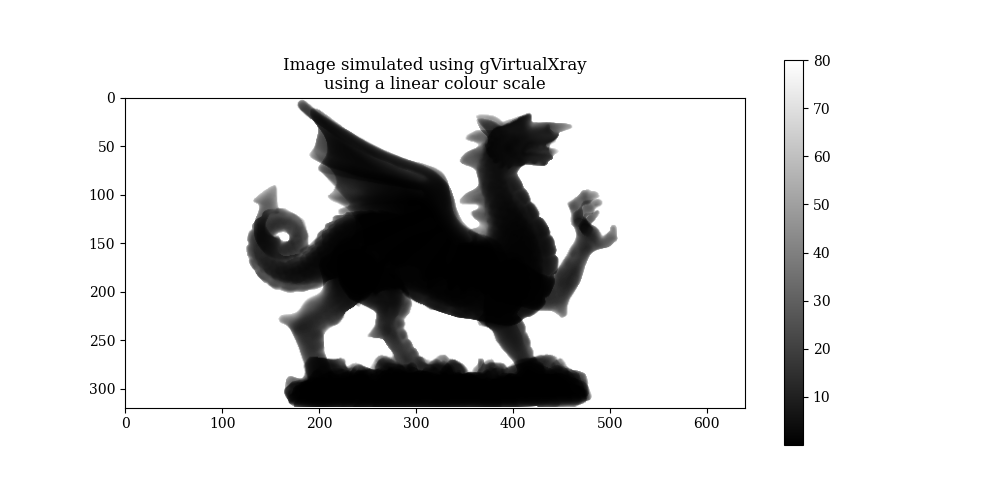

In [14]:
plt.figure(figsize=(10, 5))
plt.title("Image simulated using gVirtualXray\nusing a linear colour scale")
plt.imshow(xray_image, cmap="gray")
plt.colorbar(orientation='vertical');
plt.margins(0,0)

### using a logarithmic colour scale

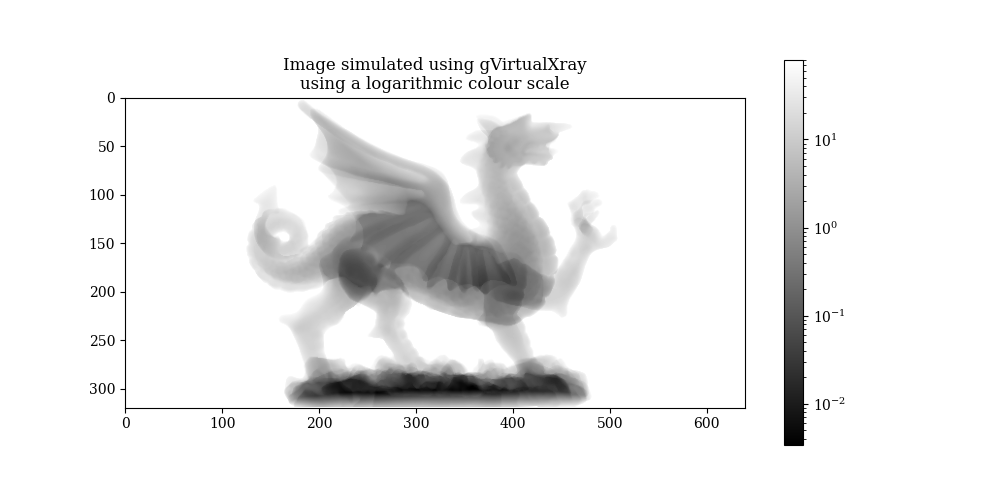

In [15]:
plt.figure(figsize=(10, 5))
plt.title("Image simulated using gVirtualXray\nusing a logarithmic colour scale")
plt.imshow(xray_image, cmap="gray", norm=LogNorm(vmin=xray_image.min(), vmax=xray_image.max()))
plt.colorbar(orientation='vertical');
plt.margins(0,0)

### Using a Power-law colour scale

In [16]:
interactPlotPowerLaw(xray_image, gamma=1.5, figsize=(10, 5))

interactive(children=(FloatSlider(value=1.5, description='gamma', max=10.0, min=0.01, step=0.5), Output()), _d…

---
### Task:

Display the X-ray image and compare three different lookup tables using

```python
gamma = ???
saveProjections(xray_image, "output_data/02-projections-dragon-Ti.pdf", gamma=gamma, figsize=(12.5, 5))
```

Replace `???` above with the value of gamma that you selected with the slider.

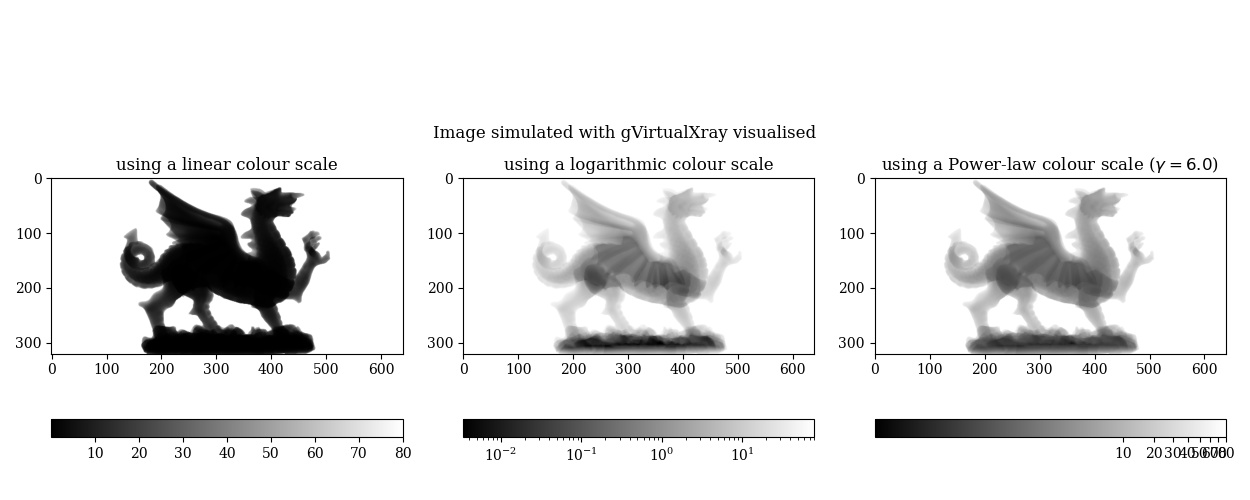

In [17]:
gamma = 6.0
saveProjections(xray_image, "output_data/02-projections-dragon-Ti.pdf", gamma=gamma, figsize=(12.5, 5))

# Double-check our results

## Get some image statistics using Numpy

we can get some image statistics using Numpy to compare with the values I got. We should get the same, or at least something comparable.

| What? | Value (in keV) |
|-------|-------|
| Min pixel value: | 0.0033831315 |
| Mean pixel value: | 56.137497 |
| Median pixel value: | 80.0 |
| Stddev pixel value: | 34.220833 |
| Max pixel value: | 80.0 |

---
### Task:

1. Print
    1. the smaller pixel value of `xray_image`;
    2. the average pixel value;
    3. the median pixel value;
    4. the standard deviation of pixel values; and
    5. the largest pixel value.
2. Compare these values with the ones above.

In [18]:
print("Min pixel value:", np.min(xray_image))
print("Mean pixel value:", np.mean(xray_image))
print("Median pixel value:", np.median(xray_image))
print("Stddev pixel value:", np.std(xray_image))
print("Max pixel value:", np.max(xray_image))

Min pixel value: 0.0033832453
Mean pixel value: 56.13751
Median pixel value: 80.0
Stddev pixel value: 34.220833
Max pixel value: 80.0


## Compare with the ground truth

We provided the ground truth image. The code below we plot, i) the ground truth, ii) the simulated image, and iii) an error map in percent. If this image is white, well done. You followed the instructions and got the results we expected. If not, there must have been an issue.

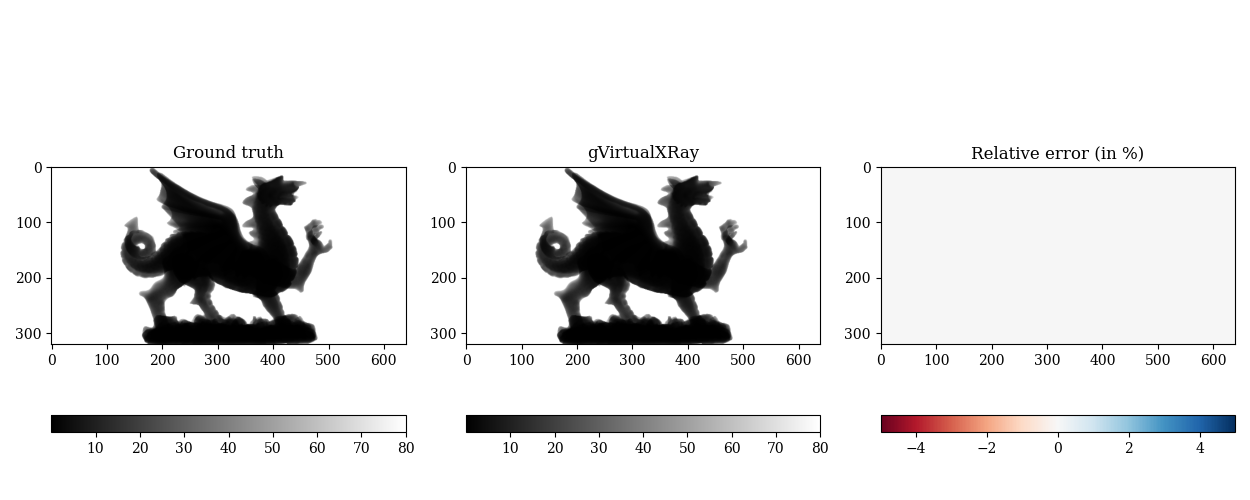

In [19]:
ground_truth = imread("../input_data/02-dragon-Ti-groundtruth.tif")
compareWithGroundTruth(ground_truth, xray_image, figsize=(12.5, 5))

# Interactive visualise in JupyterLab

By default the object is white, which is not always pretty. Let's change it to purple.

In [20]:
red = 102 / 255
green = 51 / 255
blue = 153 / 255
gvxr.setColour("Dragon", red, green, blue, 1.0)

## 3D visualisation using k3D if possible

In [21]:
plot=visualise(use_log=True)
plot.display()

Output()

In [22]:
if plot is not None:
    plot.fetch_screenshot()

    data = base64.b64decode(plot.screenshot)
    with open("output_data/02-visualisation.png",'wb') as fp:
        fp.write(data)

## Change the background colour to white

This image can be used in a research paper to illustrate the simulation environment.

In [23]:
gvxr.setWindowBackGroundColour(1.0, 1.0, 1.0)
# Don't forget to update the visualisation window
gvxr.displayScene()

## Take the screenshot and save it in a file

In [24]:
screenshot = gvxr.takeScreenshot()
plt.imsave("output_data/02-screenshot.png", np.array(screenshot))

## or display it using Matplotlib

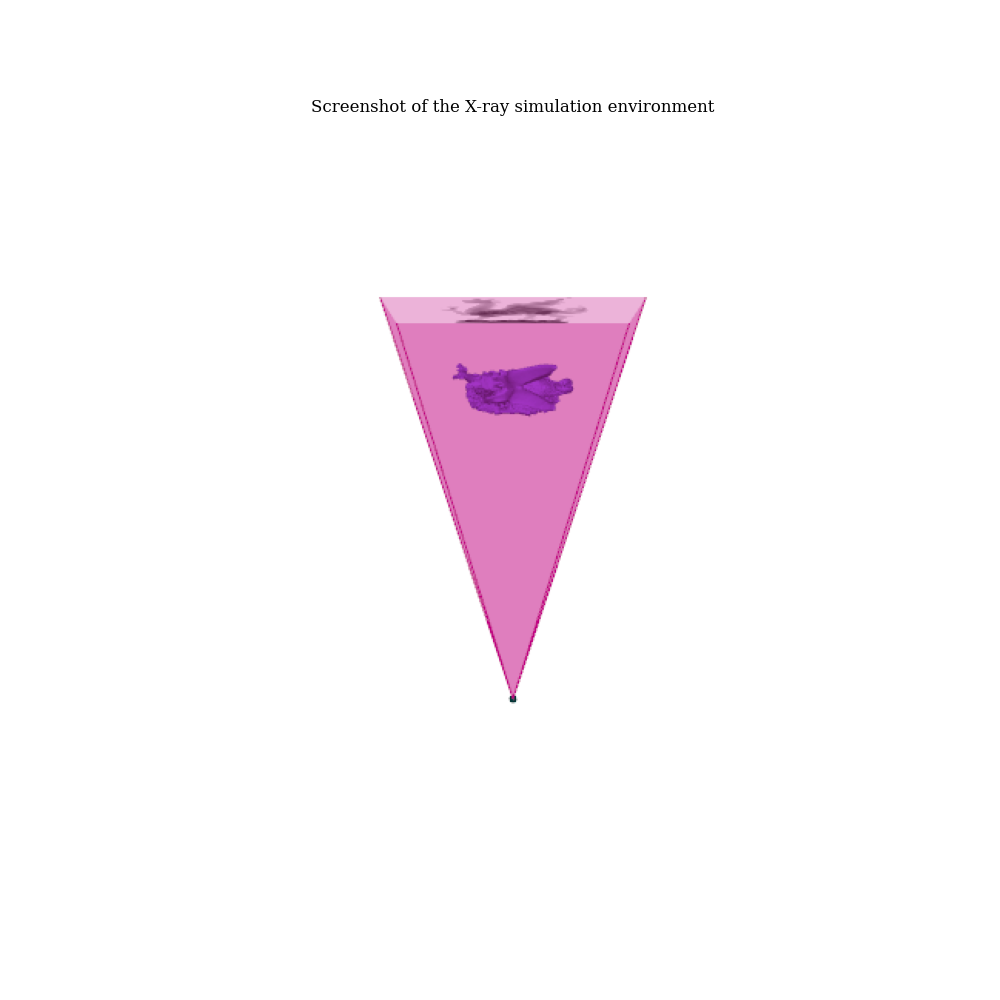

In [25]:
plt.figure(figsize=(10, 10))
plt.imshow(screenshot)
plt.title("Screenshot of the X-ray simulation environment")
plt.axis('off');

## or use the convenience function

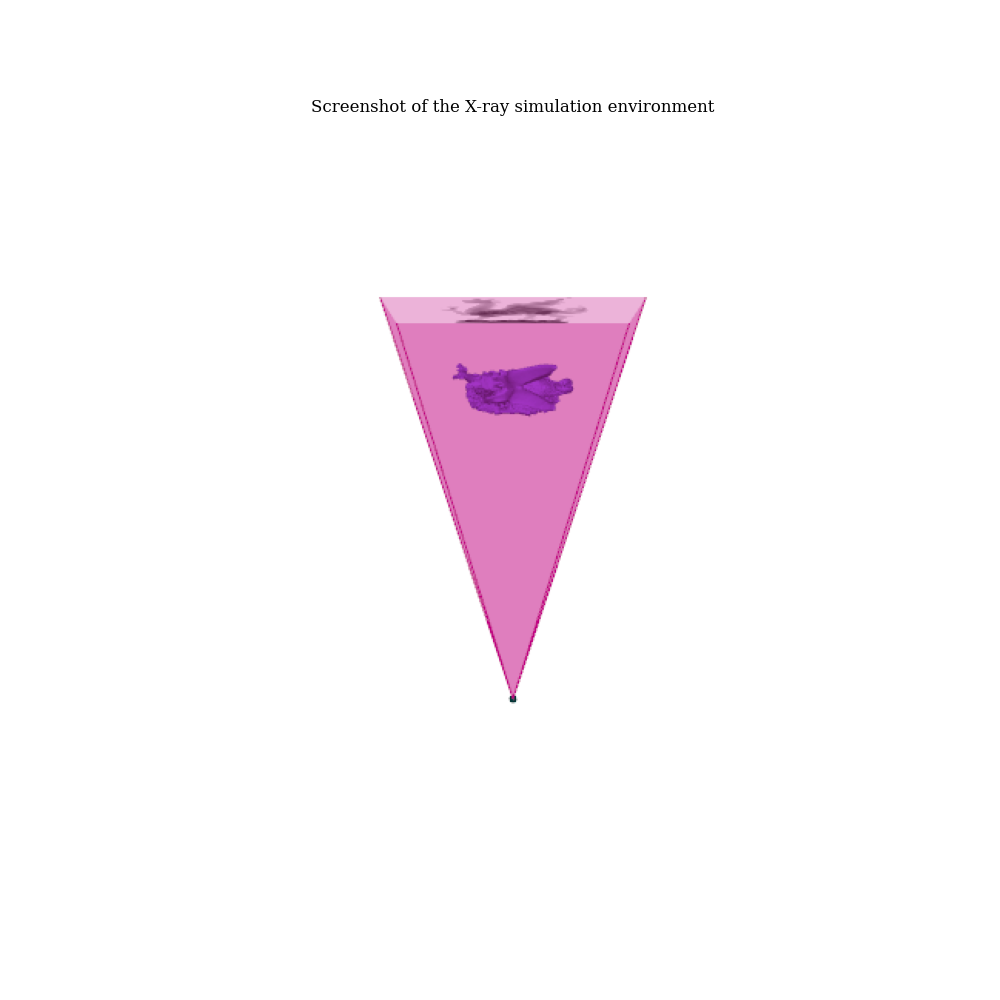

In [26]:
plotScreenshot()

## Getting an interactive view

gVXR also allows you to render the scene as an interactive view, where you can pan, rotate, zoom ect using `gvxr.renderLoop()`

When running in an interactive loop you can rotate the 3D scene and zoom-in with the mouse buttons and scroll wheel.

Useful Keys are:
- Q: Escape: to quit the event loop
- B: display/hide the X-ray beam
- W: display the polygon meshes in solid or wireframe
- N: display the X-ray image in negative or positive
- H: display/hide the X-ray detector

<div class="alert alert-block alert-warning">
<b>Note:</b> this will function only work for "OPENGL" and have no effect when using "EGL" on supercomputers or the cloud, as there is no window to render to. It will however, work on a desktop or laptop computer.
</div>

# Cleaning up

Once we have finished it is good practice to clean up the OpenGL contexts and windows with the following command.

In [27]:
gvxr.terminate()